# A representative subset of AotM-2011 Playlists with MSD Audio Features

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import gzip
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from scipy.sparse import lil_matrix, issparse
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from BinaryRelevance import BinaryRelevance
#from PClassificationMLC import PClassificationMLC
from PCMLC import PCMLC as PClassificationMLC
from evaluate import calc_F1, calc_precisionK, calc_rank, f1_score_nowarn

In [3]:
data_dir = 'data/aotm-2011'
#faotm = os.path.join(data_dir, 'aotm2011-subset.pkl')
faotm = os.path.join(data_dir, 'aotm2011-user-playlist.pkl')
ffeature = 'data/msd/songID2Features.pkl.gz'
fgenre = 'data/msd/song2genre.pkl'

## Load playlists

Load playlists.

In [4]:
user_playlists = pkl.load(open(faotm, 'rb'))

In [5]:
print('#user    :', len(user_playlists))
print('#playlist:', np.sum([len(user_playlists[u]) for u in user_playlists]))

#user    : 14182
#playlist: 84710


In [6]:
pl_lengths = [len(pl) for u in user_playlists for pl in user_playlists[u]]
#plt.hist(pl_lengths, bins=100)
print('Average playlist length: %.1f' % np.mean(pl_lengths))

Average playlist length: 10.1


In [7]:
users = sorted(user_playlists.keys())

In [8]:
songs_user = {u: {sid for pl in user_playlists[u] for sid in pl} for u in users}  # user: a set of songs

Compute the number of playlists per user, and the number of songs covered by the user's playlists.

In [9]:
udf = pd.DataFrame(index=users, columns=['#playlist', '#song'])

In [10]:
udf['#playlist'] = [len(user_playlists[u]) for u in users]

In [11]:
udf['#song'] = [len(songs_user[u]) for u in users]

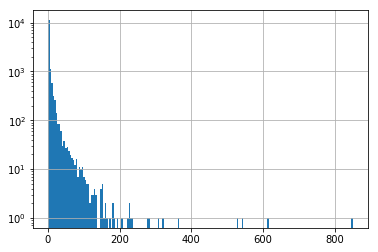

In [12]:
ax = plt.subplot(111)
udf['#playlist'].hist(bins=200, ax=ax)
ax.set_yscale('log')

In [13]:
u_npl = sorted([(u, len(user_playlists[u])) for u in users], key=lambda x: x[1])

In [14]:
#u_npl

In [15]:
step = 1000  # sample 0.1%
subset = [u_npl[ix] for ix in np.arange(0, len(u_npl), step)]

In [16]:
subset

[((914763600.0, 'Grey'), 1),
 ((1050674400.0, 'World Class Chris'), 1),
 ((1076418000.0, 'Garick'), 1),
 ((1076418000.0, 'Tom Jones'), 1),
 ((1078923600.0, 'Kurt87'), 1),
 ((1115992800.0, 'm12788'), 1),
 ((1190728800.0, 'EvaninCambridge'), 1),
 ((1058364000.0, 'Meg Usta'), 2),
 ((1092578400.0, 'XxPunk4PeacexX'), 2),
 ((1049205600.0, 'hobbitcore'), 3),
 ((1008421200.0, 'Chris Bowron'), 4),
 ((1079787600.0, 'tragic3rdwoman'), 5),
 ((1069246800.0, 'Axelsson'), 8),
 ((1012482000.0, 'lynn*'), 15),
 ((1009198800.0, 'jarød'), 62)]

In [17]:
uid_subset = [t[0] for t in subset]

In [18]:
#udf_subset = udf[ udf['#playlist'] == 10]
#udf_subset.head()

In [19]:
#uid_subset += udf_subset.index[[3,4]].tolist()

In [20]:
#udf_subset = udf[ udf['#playlist'] == 30]
#udf_subset.head()

In [21]:
#uid_subset += udf_subset.index[[1,2]].tolist()

In [22]:
#udf_subset = udf[ udf['#playlist'].isin(np.arange(95, 105))]
#udf_subset.sort_values(by='#playlist')

In [23]:
#uid_subset += udf_subset.index[[2,5]].tolist()

In [24]:
#udf.sort_values(by=['#playlist'], ascending=False).iloc[100:200]

In [25]:
#uid_subset

In [26]:
#udf[uid_subset]  # tuple are used as multiindex in pandas
#udf[[uid_subset]]

## Subset of data

The user whose playlists cover a *proper number of playlists*, e.g. 50.

In [27]:
playlists_subset = [pl for u in uid_subset for pl in user_playlists[u]]

In [28]:
len(playlists_subset)

108

In [29]:
song_set = sorted({sid for u in uid_subset for sid in songs_user[u]})

In [30]:
len(song_set)

786

### Split songs for setting I

Split songs (80/20 split) such that the distributions of song popularity (the number of occurrence in playlists) in training and dev set are similiar.

In [31]:
song_pl_mat = np.zeros((len(song_set), len(playlists_subset)))
songind = {sid: ix for ix, sid in enumerate(song_set)}
for j in range(len(playlists_subset)):
    pl = playlists_subset[j]
    ind = [songind[sid] for sid in pl]
    song_pl_mat[ind, j] = 1

In [32]:
song_pop = np.sum(song_pl_mat, axis=1)

In [33]:
#plt.hist(song_pop, bins=20)
#print()

In [34]:
#np.arange(0, 100, 5)

In [35]:
sortix = np.argsort(song_pop)
step = 5  # 80/20 split
split_ix = np.arange(0, len(song_pop), step)
dev_ix = [sortix[ix] for ix in split_ix]
dev_song_set = [song_set[ix] for ix in dev_ix]
train_song_set = sorted(set(song_set) - set(dev_song_set))

Histogram of song popularity in training set.

628


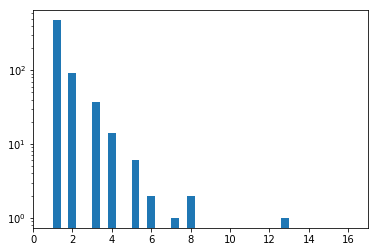

In [36]:
train_song_pop = [song_pop[songind[sid]] for sid in train_song_set]
ax = plt.subplot(111)
ax.hist(train_song_pop, bins=30)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
print(len(train_song_set))

Histogram of song popularity in dev set.

158


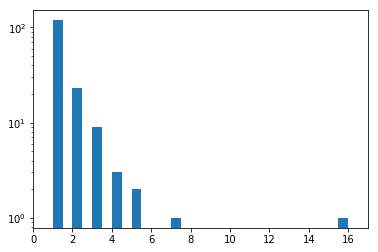

In [37]:
dev_song_pop = [song_pop[songind[sid]] for sid in dev_song_set]
ax = plt.subplot(111)
ax.hist(dev_song_pop, bins=30)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
print(len(dev_song_set))

### Split playlists

Split playlists (50/50 split) such that the distributions of playlist length (the number of songs in playlists) for each user in training and dev set are similiar.

In [38]:
train_playlists = []
dev_playlists = []

In [39]:
#np.arange(0, 10, 2)

In [40]:
for u in uid_subset:
    u_playlists = user_playlists[u]
    if len(u_playlists) < 2: 
        train_playlists.append((u, u_playlists[0]))
        continue
    sorted_pl = sorted(u_playlists, key=lambda pl: len(pl))
    step = 2
    sample_ix = np.arange(0, len(sorted_pl), step)
    if len(sample_ix) <= len(sorted_pl) / 2:
        dev_ix = sample_ix
    else:
        dev_ix = [ix for ix in range(len(sorted_pl)) if ix not in sample_ix]
    dev_playlists += [(u, sorted_pl[ix]) for ix in dev_ix]
    train_playlists += [(u, sorted_pl[ix]) for ix in range(len(sorted_pl)) if ix not in dev_ix]

In [41]:
xmax = np.max([len(pl) for pl in playlists_subset]) + 1

Histogram of playlist length in training set.

59


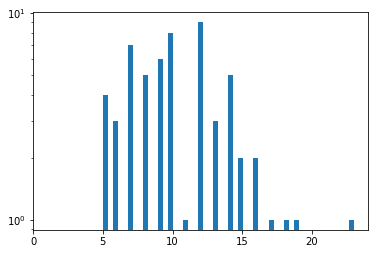

In [42]:
ax = plt.subplot(111)
ax.hist([len(t[1]) for t in train_playlists], bins=50)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
print(len(train_playlists))

Histogram of playlist length in training set.

49


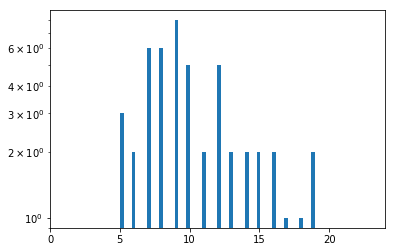

In [43]:
ax = plt.subplot(111)
ax.hist([len(t[1]) for t in dev_playlists], bins=50)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
print(len(dev_playlists))

### Split songs for setting II

Split songs such that 
- the number unknown entries is the same as that in setting I.
- the distributions of song popularity (the number of occurrence in playlists) in training and dev set are similiar.

In [44]:
num_unknown = len(playlists_subset) * len(dev_song_set)  # the number of unknown in setting I
num_dev_song2 = num_unknown / len(dev_playlists)

In [45]:
#np.arange(0, 100, 2.5)

In [46]:
sortix = np.argsort(song_pop)
step = len(song_pop) / (num_dev_song2)
split_ix = np.arange(0, len(song_pop), step)
np.random.seed(123456789)
rounding_prob = step - int(step)
dev_ix = [sortix[ix] for ix in [int(x) if np.random.rand() < rounding_prob or int(x) == len(sortix)-1 \
                                else int(x)+1 for x in split_ix]]  # avoid index out of bounds
dev_song_set2 = [song_set[ix] for ix in dev_ix]

In [47]:
print(num_unknown, len(dev_playlists) * len(dev_song_set2))

17064 17101


Histogram of song popularity in training set (all songs).

786


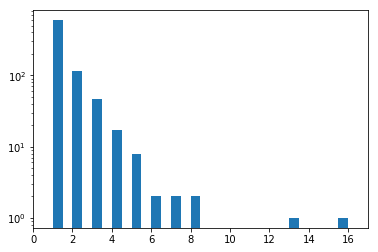

In [48]:
ax = plt.subplot(111)
ax.hist(song_pop, bins=30)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
print(len(song_set))

Histogram of song popularity in dev set.

349


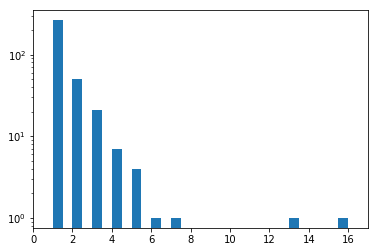

In [49]:
dev_song_pop2 = [song_pop[songind[sid]] for sid in dev_song_set2]
ax = plt.subplot(111)
ax.hist(dev_song_pop2, bins=30)
ax.set_yscale('log')
ax.set_xlim(0, song_pop.max()+1)
print(len(dev_song_set2))

## Load song features

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [50]:
song2Features = pkl.load(gzip.open(ffeature, 'rb'))

## Load genres

In [51]:
song2genre = pkl.load(open(fgenre, 'rb'))

Check if all songs have genre info.

In [52]:
np.all([sid in song2genre for sid in song_set])

False

## Create song-playlist matrix

Songs as rows, playlists as columns.

In [53]:
def gen_dataset_subset(playlists, song_set, features_MSD, song2genre):
    """
    Create labelled dataset: rows are songs, columns are users.
    
    Input:
        - playlists: a set of playlists
        - song_set: a set of songIDs
        - features_MSD: dictionary that maps songIDs to features from MSD
        - song2genre: dictionary that maps songIDs to genre
    Output:
        - (Feature, Label) pair (X, Y)
          X: #songs by #features
          Y: #songs by #users
    """ 
    song_indices = {sid: ix for ix, sid in enumerate(song_set)}
    N = len(song_set)
    K = len(playlists)
    
    genre_set = sorted({v for v in song2genre.values()})
    genre_indices = {genre: ix for ix, genre in enumerate(genre_set)}
    
    def onehot_genre(songID):
        """
        One-hot encoding of genres.
        Data imputation: one extra entry for songs without genre info.
        Should try other options: 
            mean imputation, sampling from the distribution of genre popularity.
        """
        num = len(genre_set) + 1
        vec = np.zeros(num, dtype=np.float)
        if songID in song2genre:
            genre_ix = genre_indices[song2genre[songID]]
            vec[genre_ix] = 1
        else:
            vec[-1] = 1
        return vec
    
    #X = np.array([features_MSD[sid] for sid in song_set])  # without using genre
    X = np.array([np.concatenate([features_MSD[sid], onehot_genre(sid)], axis=-1) for sid in song_set])
    Y = np.zeros((N, K), dtype=np.bool)
    
    for k in range(K):
        pl = playlists[k]
        indices = [song_indices[sid] for sid in pl if sid in song_indices]
        Y[indices, k] = True

    return X, Y

In [54]:
def mean_normalised_reciprocal_rank(Y_true, Y_pred):
    """
    Compute the mean of normalised reciprocal rank (reciprocal rank are normalised by the best possible ranks)
    """
    normalised_reci_rank = []
    npos = np.sum(Y_true, axis=0)
    for k in range(Y_true.shape[1]):
        ranks = calc_rank(Y_pred[:, k])[Y_true[:, k]]
        if len(ranks) > 0:
            ideal = np.sum([1./nk for nk in range(1, npos[k]+1)])
            real = np.sum([1./r for r in ranks])
            normalised_reci_rank.append(real / ideal)  # normalise the reciprocal ranks by the best possible ranks
    return np.mean(normalised_reci_rank)

## Setting I: hold a subset of songs, use all playlists

In [55]:
playlists1 = [t[1] for t in train_playlists + dev_playlists]

In [56]:
X_train, Y_train = gen_dataset_subset(playlists=playlists1, song_set=train_song_set, 
                                      features_MSD=song2Features, song2genre=song2genre)

In [57]:
X_dev, Y_dev = gen_dataset_subset(playlists=playlists1, song_set=dev_song_set, 
                                  features_MSD=song2Features, song2genre=song2genre)

Feature normalisation.

In [58]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_dev   -= X_train_mean
X_dev   /= X_train_std

In [59]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))

Train:      (628, 218)      (628, 108)
Dev  :      (158, 218)      (158, 108)


In [60]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 1)
print(np.mean(np.mean(X_dev, axis=0)))
print(np.mean( np.std(X_dev, axis=0)) - 1)

-7.44259713994e-17
-0.0459013902717
-0.0302534229084
0.0366010807539


In [61]:
#np.sum(Y_train, axis=0)

In [62]:
#np.sum(Y_dev, axis=0)

### M1. BR - Independent logistic regression

In [63]:
br = BinaryRelevance(C=1, n_jobs=4)
br.fit(X_train, Y_train)

In [64]:
Y_br = br.predict(X_dev)

Evaluation: normalise **per playlist**.

In [65]:
print('Mean P@K:', np.mean(calc_precisionK(Y_dev.T, Y_br.T)))

Mean P@K: 0.171759259259


In [66]:
print('Mean macro-F1:', f1_score_nowarn(Y_dev.T, Y_br.T>=0, average='macro'))

Mean macro-F1: 0.00660429279031


In [67]:
nzcol = np.nonzero(np.sum(Y_dev, axis=0))[0]  # columns with at least one True

In [68]:
print('Mean AUC:', roc_auc_score(Y_dev[:, nzcol], Y_br[:, nzcol], average='macro'))

Mean AUC: 0.559377098897


In [69]:
print('MAP:', average_precision_score(Y_dev[:, nzcol], Y_br[:, nzcol], average='macro'))

MAP: 0.0651904895492


In [70]:
#print('P, R, F1:',precision_recall_fscore_support(Y_dev.ravel(), (Y_br>=0).ravel(),average='binary', warn_for=()))

In [71]:
print('Mean normalised reciprocal rank:', mean_normalised_reciprocal_rank(Y_dev, Y_br))

Mean normalised reciprocal rank: 0.0791191750439


P@K, MAP, NDCG, AUC are good options.

In [72]:
%%script false
min_pos_score = []
for col in range(Y_dev.shape[1]):
    val = Y_br[:,col][Y_dev[:,col]]
    if len(val) > 0:
        min_pos_score.append(np.min(val))
    else:
        min_pos_score.append(np.nan)
print(np.array(min_pos_score))

In [73]:
%%script false
max_neg_score = []
for col in range(Y_dev.shape[1]):
    val = Y_br[:,col][np.logical_not(Y_dev[:,col])]
    if len(val) > 0:
        max_neg_score.append(np.max(val))
print(np.array(max_neg_score))

In [74]:
#print(np.array(min_pos_score)-np.array(max_neg_score))

### M2. PC - Multilabel p-classification

P-Classification ~ P-norm push ranking.

In [75]:
pc1 = PClassificationMLC(C=1, weighting=True, verticalWeighting=True)
pc1.fit(X_train, Y_train)


C: 1, p: 1, weighting: True


In [76]:
X_test = X_dev
Y_test = Y_dev

In [77]:
Y_pc = pc1.predict(X_test)

Evaluation: normalise **per playlist**.

In [78]:
print('Mean P@K:', np.mean(calc_precisionK(Y_test.T, Y_pc.T)))

Mean P@K: 0.173148148148


In [79]:
print('Mean macro-F1:', f1_score_nowarn(Y_test.T, Y_pc.T>=0, average='macro'))

Mean macro-F1: 0.0387358019868


In [80]:
nzcol = np.nonzero(np.sum(Y_test, axis=0))[0]  # columns with at least one True

In [81]:
print('Mean AUC:', roc_auc_score(Y_test[:, nzcol], Y_pc[:, nzcol], average='macro'))

Mean AUC: 0.671206587561


In [82]:
print('MAP:', average_precision_score(Y_test[:, nzcol], Y_pc[:, nzcol], average='macro'))

MAP: 0.0880778250386


In [83]:
print('Mean normalised reciprocal rank:', mean_normalised_reciprocal_rank(Y_test, Y_pc))

Mean normalised reciprocal rank: 0.101846244957


In [84]:
min_pos_score = []
for col in range(Y_test.shape[1]):
    val = Y_pc[:,col][Y_test[:,col]]
    if len(val) > 0:
        min_pos_score.append(np.min(val))
    else:
        min_pos_score.append(np.nan)
#plt.hist((np.array(min_pos_score)))
#plt.hist((np.nan_to_num(min_pos_score)), bins=30)
#print(np.array(min_pos_score))
#print()

In [85]:
max_neg_score = []
for col in range(Y_test.shape[1]):
    val = Y_pc[:,col][np.logical_not(Y_test[:,col])]
    if len(val) > 0:
        max_neg_score.append(np.max(val))
#plt.hist(np.array(max_neg_score), bins=30)
#print()

In [86]:
#plt.hist(np.nan_to_num(min_pos_score)-np.array(max_neg_score), bins=30)
#print()

## Setting II: hold a subset of playlists, use all songs

### M3. Multilabel p-classification with some playlist fully observed

In [87]:
nondev_song_set2 = sorted({sid for sid in song_set if sid not in dev_song_set2})
print(len(nondev_song_set2) + len(dev_song_set2), len(song_set))

786 786


In [88]:
playlists2 = [t[1] for t in train_playlists + dev_playlists]

In [89]:
X, Y = gen_dataset_subset(playlists=playlists2, song_set=nondev_song_set2 + dev_song_set2, 
                          features_MSD=song2Features, song2genre=song2genre)

In [90]:
Y_train = Y.copy().astype(np.float)  # note: np.nan is float
Y_train[len(nondev_song_set2):, len(train_playlists):] = np.nan
Y_dev = Y[-len(dev_song_set2):, -len(dev_playlists):]

In [91]:
#Y_train

In [92]:
print(np.sum(np.isnan(Y_train)), len(dev_playlists) * len(dev_song_set2))

17101 17101


In [93]:
X_train = X

Feature normalisation.

In [94]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_dev = X_train[len(nondev_song_set2):]

In [95]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))

Train:      (786, 218)      (786, 108)
Dev  :      (349, 218)       (349, 49)


In [96]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 1)
print(np.mean(np.mean(X_dev, axis=0)))
print(np.mean( np.std(X_dev, axis=0)) - 1)

3.43710489009e-17
-0.0458900154908
0.0029949467376
-0.060802933072


In [97]:
#np.sum(Y_train, axis=0)

In [98]:
#np.sum(Y_dev, axis=0)

In [99]:
user_of_playlists2 = [t[0] for t in train_playlists + dev_playlists]
#user_of_playlists2

In [100]:
same_user_mat = np.zeros((len(playlists2), len(playlists2)), dtype=np.bool)
for i in range(len(playlists2)):
    for j in range(i+1, len(playlists2)):
        if user_of_playlists2[i] == user_of_playlists2[j]:
            same_user_mat[i, j] = True
            same_user_mat[j, i] = True

In [101]:
#same_user_mat

In [102]:
pla = PClassificationMLC(C=1, weighting=True, verticalWeighting=True, similarMat=same_user_mat)
pla.fit(X_train, Y_train)


C: 1, p: 1, weighting: True


In [103]:
Y_pla = pla.predict(X_dev)[:, -len(dev_playlists):]

Evaluation: normalise **per playlist**.

In [104]:
print('Mean P@K:', np.mean(calc_precisionK(Y_dev.T, Y_pla.T)))

Mean P@K: 0.0199546485261


In [105]:
print('Mean macro-F1:', f1_score_nowarn(Y_dev.T, Y_pla.T>=0, average='macro'))

Mean macro-F1: 0.032017195166


In [106]:
nzcol = np.nonzero(np.sum(Y_dev, axis=0))[0]  # columns with at least one True

In [107]:
print('Mean AUC:', roc_auc_score(Y_dev[:, nzcol], Y_pla[:, nzcol], average='macro'))

Mean AUC: 0.605977270558


In [108]:
print('MAP:', average_precision_score(Y_dev[:, nzcol], Y_pla[:, nzcol], average='macro'))

MAP: 0.0424092519376


In [109]:
print('Mean normalised reciprocal rank:', mean_normalised_reciprocal_rank(Y_dev, Y_pla))

Mean normalised reciprocal rank: 0.0522068460816


## M4. Multilabel p-classification with unknows in test set

In [ ]:
N, K = Y.shape

In [ ]:
#type(np.nan)

In [ ]:
Y_nan = Y.copy().astype(np.float)
np.random.seed(8967321)
rand_num = int(0.2 * N)
ones = 0
for k in range(K):
    randix = np.random.permutation(np.arange(N))[:rand_num]
    Y_nan[randix, k] = np.nan
    ones += Y[randix, k].sum()

In [ ]:
#np.sum(Y, axis=0)

In [ ]:
#np.nansum(Y_nan, axis=0)

In [ ]:
#np.sum(Y, axis=0) - np.nansum(Y_nan, axis=0)

In [ ]:
#ones  # number of positive entries selected to be masked as NaN

In [ ]:
#Y.shape

In [ ]:
#Y_nan.shape

The number of NaN entries.

In [ ]:
np.sum(np.isnan(Y_nan))

In [ ]:
#np.sum(Y)

Train: *keep running util no overflow warning occurred*.

In [ ]:
pc2 = PClassificationMLC(weighting=True, verticalWeighting=True)
pc2.fit(X, Y_nan)

Prediction: use the minimum of positive entry score of the same example as threshold.  
Evaluation: use F1 on all unknown entries (as a 1D array).

In [ ]:
Y_pred2 = pc2.predict(X)

In [ ]:
pos_index = np.nan_to_num(Y_nan).astype(np.bool)
nan_index = np.isnan(Y_nan)

In [ ]:
ground_truths = Y[nan_index]

In [ ]:
thresholds = []
preds = []
for k in range(K):
    val = Y_pred2[:, k][pos_index[:, k]]
    th = np.min(val)
    thresholds.append(th)
    preds += (Y_pred2[nan_index[:,k], k] >= th).tolist()

In [ ]:
f1_score_nowarn(ground_truths, preds, average='binary')

In [ ]:
precision_recall_fscore_support(ground_truths, preds, average='binary', warn_for=None)

## M5. Multilabel p-classification w/ (some playlist fully observed) & (unknowns in test set)

In [ ]:
N, K = Y.shape

In [ ]:
Y_nan_part2 = Y.copy().astype(np.float)
np.random.seed(8967321)
rand_num = int(0.4 * N)
ones = 0
for k in range(int(K/2), K):
    randix = np.random.permutation(np.arange(N))[:rand_num]
    Y_nan_part2[randix, k] = np.nan
    ones += Y[randix, k].sum()

In [ ]:
#np.sum(Y, axis=0)

In [ ]:
#np.nansum(Y_nan_part, axis=0)

In [ ]:
#np.sum(Y, axis=0) - np.nansum(Y_nan_part, axis=0)

In [ ]:
#ones  # number of positive entries selected to be masked as NaN

In [ ]:
#Y.shape

In [ ]:
#Y_nan.shape

The number of NaN entries.

In [ ]:
np.sum(np.isnan(Y_nan_part2))

In [ ]:
#np.sum(Y)

In [ ]:
pc4 = PClassificationMLC(weighting=True, verticalWeighting=True)
pc4.fit(X, Y_nan_part2)

Prediction: use the minimum of positive entry score of the same example as threshold.  
Evaluation: use F1 on all unknown entries (as a 1D array).

In [ ]:
Y_pred4 = pc4.predict(X)

In [ ]:
pos_index = np.nan_to_num(Y_nan_part2).astype(np.bool)
nan_index = np.isnan(Y_nan_part2)

In [ ]:
ground_truths = Y[nan_index]

In [ ]:
thresholds = []
preds = []
for k in range(int(K/2), K):
    val = Y_pred4[:, k][pos_index[:, k]]
    th = np.min(val)
    #th = np.mean(val)
    thresholds.append(th)
    preds += (Y_pred4[nan_index[:,k], k] >= th).tolist()

In [ ]:
#np.sum(ground_truths)

In [ ]:
#np.sum(preds)

In [ ]:
f1_score_nowarn(ground_truths, preds, average='binary')

In [ ]:
precision_recall_fscore_support(ground_truths, preds, average='binary', warn_for=None)

In [ ]:
np.sum(ground_truths)

In [ ]:
np.sum(preds)

In [ ]:
np.sum(np.logical_and(ground_truths, preds))

In [ ]:
2 * np.sum(np.logical_and(ground_truths, preds)) / (np.sum(ground_truths) + np.sum(preds))